In [1]:
import os

In [2]:
%pwd

'd:\\Projects\\DeepFake Voice Recognition\\audio-deepfake-detection\\research'

In [3]:
os.chdir('../')

In [4]:
%pwd

'd:\\Projects\\DeepFake Voice Recognition\\audio-deepfake-detection'

In [5]:
labels = os.listdir('artifacts/data_ingestion/KAGGLE/AUDIO/')
labels.reverse()
print(labels)

['REAL', 'FAKE']


In [6]:
for label, folder in enumerate(labels):
    print(f'{label} - {folder}')

0 - REAL
1 - FAKE


In [7]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [8]:
real_path = 'artifacts/data_ingestion/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3'
fake_path = 'artifacts/data_ingestion/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3'

The sampling rate of the original file is 44100 Hz.


Text(0.5, 1.0, 'Real Audio Time Series')

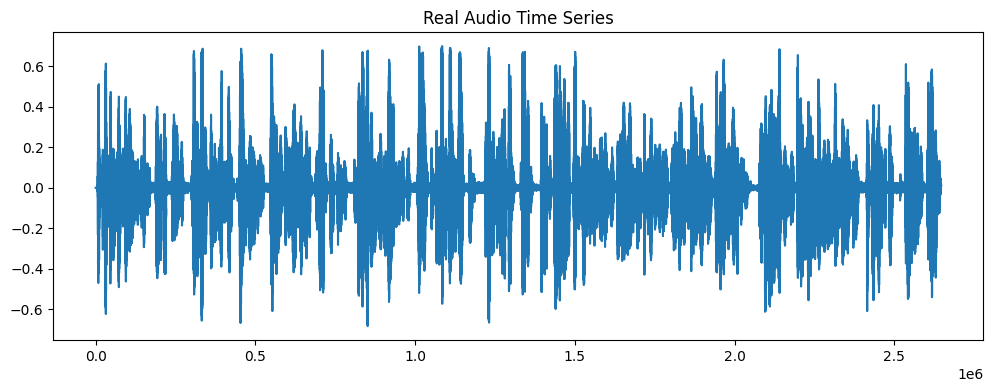

In [9]:
# Plotting real audio time series
real_aud, real_srate = librosa.load(real_path, sr = None)
print(f"The sampling rate of the original file is {real_srate} Hz.")
plt.figure(figsize=(12,4))
plt.plot(real_aud)
plt.title('Real Audio Time Series')

The sampling rate of the deepfaked file is 44100 Hz.


Text(0.5, 1.0, 'Fake Audio Time Series')

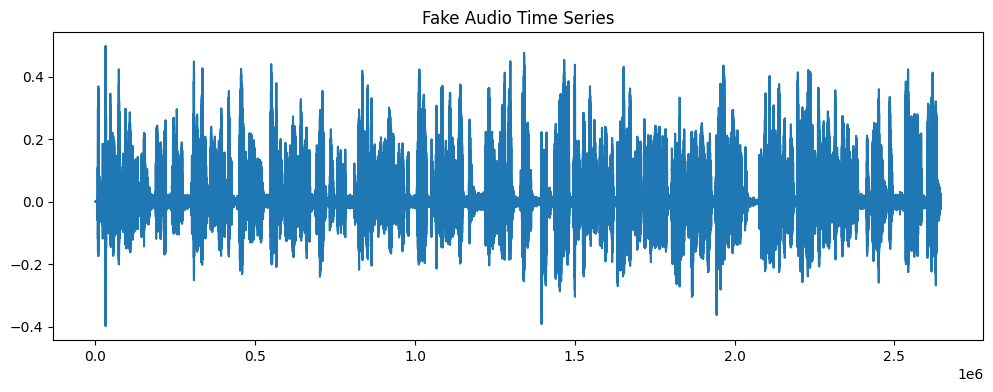

In [10]:
# Plotting fake audio time series
fake_aud, fake_srate = librosa.load(fake_path, sr = None)
print(f"The sampling rate of the deepfaked file is {fake_srate} Hz.")
plt.figure(figsize=(12,4))
plt.plot(fake_aud)
plt.title('Fake Audio Time Series')

In [11]:
# Length and sampling rate of real audio set by default by Librosa
real_aud_defload, real_srate_defload = librosa.load(real_path)
print(f"The sampling rate of the original file when loaded through librosa is {real_srate_defload} Hz.")
real_aud_len = len(real_aud_defload)
print(f"The length of the original audio series is {real_aud_len}.")

The sampling rate of the original file when loaded through librosa is 22050 Hz.
The length of the original audio series is 1323000.


In [12]:
# Sampling rate of real audio when manually set to 16000 Hz when loading
real_aud_16k, real_srate_16k = librosa.load(real_path, sr = 16000)
print(f"The sampling rate of the original file when is manually set to {real_srate_16k} Hz when loading.")

The sampling rate of the original file when is manually set to 16000 Hz when loading.


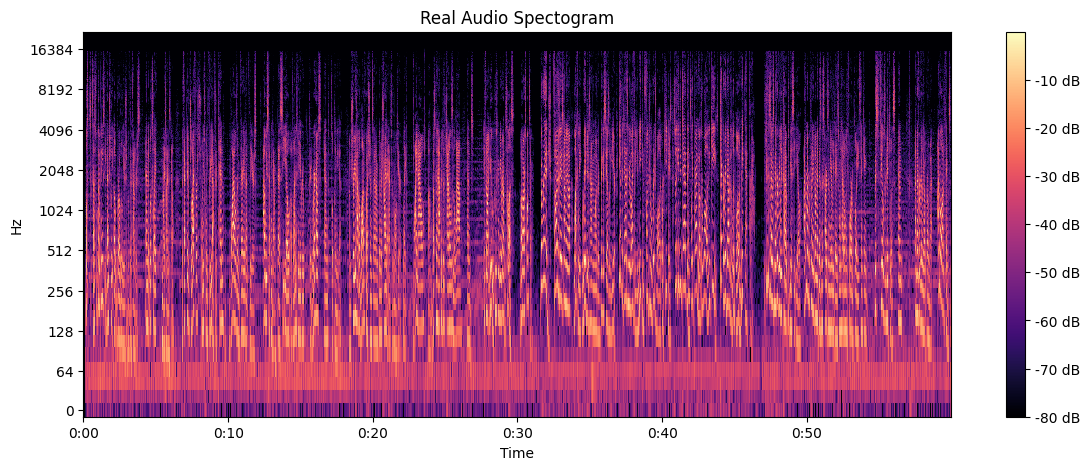

In [13]:
# Plotting a spectrogram of the real audio
real_spec = np.abs(librosa.stft(real_aud))
real_spec = librosa.amplitude_to_db(real_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec, sr = real_srate, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Audio Spectogram")
plt.show()

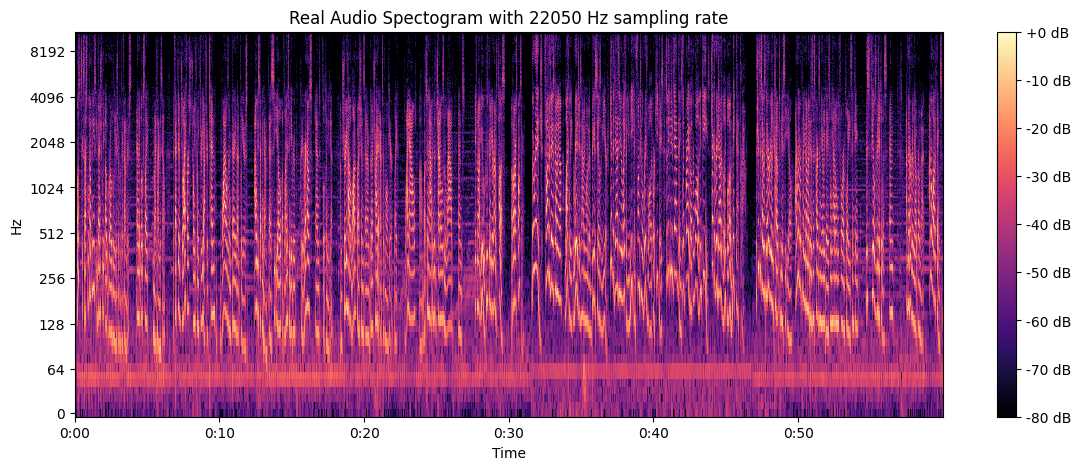

In [14]:
# Plotting a spectrogram of the real audio with 22050 Hz sampling rate
real_spec_defload = np.abs(librosa.stft(real_aud_defload))
real_spec_defload = librosa.amplitude_to_db(real_spec_defload, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec_defload, sr = real_srate_defload, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Audio Spectogram with 22050 Hz sampling rate")
plt.show()

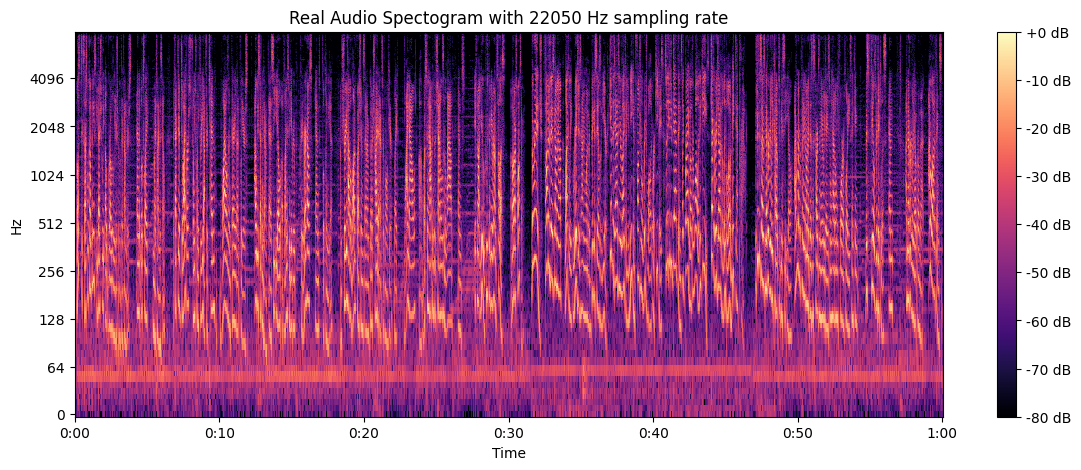

In [15]:
# Plotting a spectrogram of the real audio with 16000 Hz sampling rate
real_spec_16k = np.abs(librosa.stft(real_aud_16k))
real_spec_16k = librosa.amplitude_to_db(real_spec_16k, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec_16k, sr = real_srate_16k, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Audio Spectogram with 22050 Hz sampling rate")
plt.show()

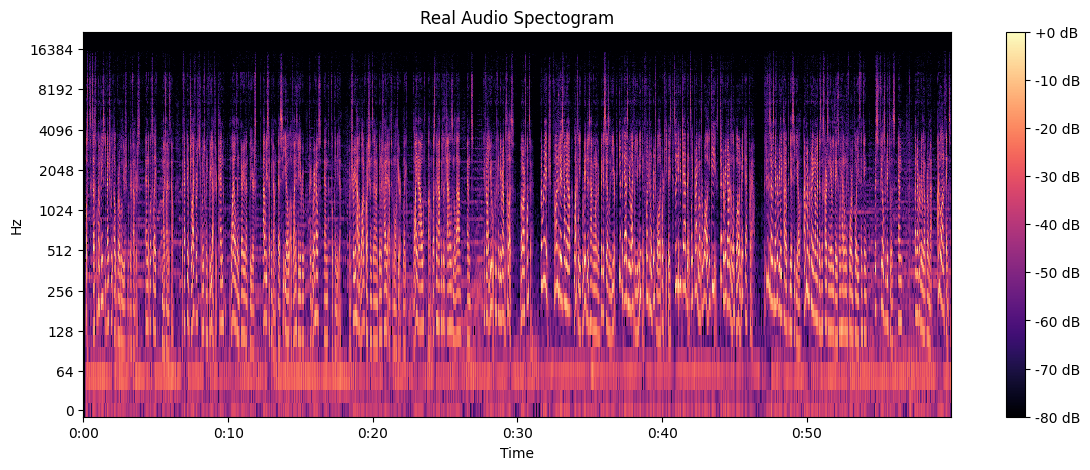

In [16]:
# Plotting a spectrogram of the fake audio
fake_spec = np.abs(librosa.stft(fake_aud))
fake_spec = librosa.amplitude_to_db(fake_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_spec, sr = fake_srate, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Audio Spectogram")
plt.show()

In [17]:
import tensorflow as tf 
import tensorflow_io as tfio

In [18]:
def load_wav_16k_mono_librosa(filename):
    # Load encoded wav file
    aud, _ = librosa.load(filename, sr = 16000, mono = True)
    return aud

In [19]:
lengths = []
for file in os.listdir(os.path.join('artifacts/data_ingestion/KAGGLE/AUDIO/', 'FAKE')):
    audio = load_wav_16k_mono_librosa(os.path.join('artifacts/data_ingestion/KAGGLE/AUDIO/', 'FAKE', file))
    lengths.append(len(audio))

In [20]:
print(np.mean(lengths))
print(np.min(lengths))
print(np.max(lengths))

7487070.375
1271796
9600000


In [21]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path
    sampling_rate: int
    n_fft: int
    max_length: int

In [22]:
from audioClassifier.constants import *
from audioClassifier.utils.common import open_yaml_file, create_directories

In [23]:
class ConfigManager:
    def __init__(self, config_file = CONFIG_PATH, params_file = PARAMS_PATH):
        self.config = open_yaml_file(config_file)
        self.params = open_yaml_file(params_file)
        
        create_directories([self.config.artifacts_root])
        create_directories([self.config.data_transformation.root_dir])
        
    def read_data_trans_config(self) -> DataTransformationConfig:
        data_trans = self.config.data_transformation
        
        data_trans_config = DataTransformationConfig(
            root_dir = data_trans.root_dir,
            data_path = data_trans.data_path,
            sampling_rate = data_trans.sampling_rate,
            n_fft = data_trans.n_fft,
            max_length = data_trans.max_length   
        )
        
        return data_trans_config

In [24]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from audioClassifier import logger

In [25]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
    
    def load_data(self):
        data, labels = self._load_audio_data()
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state=42)
        np.save(os.path.join(self.config.root_dir, "X_train.npy"), X_train)
        np.save(os.path.join(self.config.root_dir, "X_test.npy"), X_test)
        np.save(os.path.join(self.config.root_dir, "y_train.npy"), y_train)
        np.save(os.path.join(self.config.root_dir, "y_test.npy"), y_test)
        logger.info("Split data and labels into training and test sets.")
        logger.info(f"Shape of X_train - {X_train.shape}")
        logger.info(f"Shape of X_test - {X_test.shape}")
        logger.info(f"Shape of y_train - {y_train.shape}")
        logger.info(f"Shape of y_test - {y_test.shape}")
        
    def _load_audio_data(self):
        data = []
        labels = []
        folders = os.listdir(self.config.data_path)
        folders.reverse()
        for label, folder in enumerate(folders):
            folder_path = os.path.join(self.config.data_path, folder)
            for filename in os.listdir(folder_path):
                if filename.endswith('.wav') or filename.endswith('.mp3'):
                    filepath = os.path.join(folder_path, filename)
                    try:
                        data.append(self._process_audio(filepath))
                        labels.append(label)
                    except Exception as e:
                        logger.error(f"Error processing audio file: {filepath}, Error: {e}")
                    
        X = np.array(data)
        y = np.array(labels)

        return X, y
        
    def _process_audio(self, filepath: Path):
        try:
            audio = self._load_and_resample_audio(filepath)
            audio = self._pad_or_truncate_audio(audio)
            spectrogram = self._compute_spectrogram(audio)
            return spectrogram
        except Exception as e:
            logger.error(f"Error processing audio file: {filepath}, Error: {e}")
            raise
        
    def _load_and_resample_audio(self, filepath: Path):
        try:
            audio, _ = librosa.load(filepath, sr = self.config.sampling_rate, mono = True)
            return audio
        except Exception as e:
            logger.error(f"Error loading audio file: {filepath}, Error: {e}")
            raise
        
    def _pad_or_truncate_audio(self, audio):
        audio_length = len(audio)
        desired_length = self.config.max_length
        try:
            if audio_length < desired_length:
                padding = desired_length - audio_length
                audio = np.pad(audio, (0, padding), mode='constant')
            else:
                audio = audio[:desired_length]
            return audio
        except Exception as e:
            logger.error(f"Error padding/truncating audio: {e}")
            raise

    def _compute_spectrogram(self, audio):
        try:
            spectrogram = np.abs(librosa.stft(y = audio, n_fft = self.config.n_fft))
            spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
            return spectrogram
        except Exception as e:
            logger.error(f"Error computing spectrogram: {e}")
            raise
            

In [26]:
try:
    config = ConfigManager()
    data_transformation_config = config.read_data_trans_config()
    data_transformation = DataTransformation(config = data_transformation_config)
    data_transformation.load_data()
except Exception as e:
    raise e

2024-04-27 19:41:21,321 - common.py - INFO - YAML file 'config\config.yaml' was loaded successfully.
2024-04-27 19:41:21,322 - common.py - INFO - YAML file 'params.yaml' was loaded successfully.
2024-04-27 19:41:21,323 - common.py - INFO - Directory 'artifacts' created successfully or already exists.
2024-04-27 19:41:21,324 - common.py - INFO - Directory 'artifacts/data_transformation' created successfully or already exists.
2024-04-27 19:42:12,067 - 3056783526.py - INFO - Split data and labels into training and test sets.
2024-04-27 19:42:12,067 - 3056783526.py - INFO - Shape of X_train - (51, 257, 57813)
2024-04-27 19:42:12,067 - 3056783526.py - INFO - Shape of X_test - (13, 257, 57813)
2024-04-27 19:42:12,067 - 3056783526.py - INFO - Shape of y_train - (51,)
2024-04-27 19:42:12,067 - 3056783526.py - INFO - Shape of y_test - (13,)
